In [21]:
import pandas as pd
DATASET = "sentiment_ds.csv"
import logging
import warnings
import sys
import matplotlib.pyplot as plt

from nltk.corpus import wordnet
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
logging.disable(sys.maxsize)



In [22]:
ds = pd.read_csv(DATASET, error_bad_lines=False, header=0, warn_bad_lines=False) 
# there are some malformed entries the dataset... let's ignore those for now


In [23]:
len(ds.index)

2393238

In [25]:
### Let's see what the dataset looks like... 
ds.head()


,Unnamed: 0,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,sentiment_score
0,0,US,42521656,R26MV8D0KG6QI6,B000SAQCWC,159713740,"The Cravings Place Chocolate Chunk Cookie Mix,...",Grocery,5.0,0.0,0.0,N,Y,Using these for years - love them.,"As a family allergic to wheat, dairy, eggs, nu...",2015-08-31,0.8096
1,1,US,12049833,R1OF8GP57AQ1A0,B00509LVIQ,138680402,"Mauna Loa Macadamias, 11 Ounce Packages",Grocery,5.0,0.0,0.0,N,Y,Wonderful,"My favorite nut. Creamy, crunchy, salty, and ...",2015-08-31,0.6915
2,2,US,107642,R3VDC1QB6MC4ZZ,B00KHXESLC,252021703,Organic Matcha Green Tea Powder - 100% Pure Ma...,Grocery,5.0,0.0,0.0,N,N,Five Stars,This green tea tastes so good! My girlfriend l...,2015-08-31,0.8286
3,3,US,6042304,R12FA3DCF8F9ER,B000F8JIIC,752728342,15oz Raspberry Lyons Designer Dessert Syrup Sauce,Grocery,5.0,0.0,0.0,N,Y,Five Stars,I love Melissa's brand but this is a great sec...,2015-08-31,0.8500
4,4,US,18123821,RTWHVNV6X4CNJ,B004ZWR9RQ,552138758,"Stride Spark Kinetic Fruit Sugar Free Gum, 14-...",Grocery,5.0,0.0,0.0,N,Y,Five Stars,good,2015-08-31,0.4404


In [13]:

def filter_bad_star(row):
    '''
    determine if a row is a negative review based on its score. Potentially extend it to include sentiment analysis 
    and presence of specific negative words 
    '''
    return row["star_rating"].astype(int) <=3

def filter_good_star(row):
    '''
    determine if a row is a positive review based on its score.
    '''
    return row["star_rating"].astype(int) > 3

In [67]:
import nltk
import gensim
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [124]:
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS:
            result.append(WordNetLemmatizer().lemmatize(token, "v")) # for now, lemmatizing only verbs
    return result

In [125]:
preprocess("sickening")

['sicken']

In [175]:
bad_words = [
    "stink",
    "stinky",
    "stinking",
    "stank",
    "stunk",

    "sick",
    "sickening",
    "nauseous",
    "throw up",

    "poison",
    "poisoned",
    "poisoning"
    
    "moldy",
    "mouldy",

    "rotted",
    "rotten",
    "rotting",

    "stale",

    "curdled",

    "danger",
    "dangerous",
    "unsafe",
    "avoid",

    "ammonia",
    "ill",

    "queasy",
    "dizzy",
]

In [176]:
# How do we account for spelling mistakes? Do we need to?

def filter_bad_words(row):
    '''
    determine if a row is a negative review based on its words.
    '''
    return row["review_body"].str.contains("\\b(%s)\\b" % '|'.join(bad_words))

In [177]:
bad_words_rows = ds.loc[filter_bad_words]
len(bad_words_rows.index)

41249

In [178]:
bad_words_rows.head()

,Unnamed: 0,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,sentiment_score,n_reviews
5,5,US,23649464,RIG9AWFOGRDVO,B00AL6QBZ6,681475449,Herr's Popcorn Hot Cheese 1 Oz (Pack of 30),Grocery,2.0,1.0,1.0,N,Y,Not Happy,The popcorn was stale.,2015-08-31,0.0000,8
17,17,US,22765168,R3T6TTD2IN0EFZ,B00XDXMLL2,971154239,"Skippy Creamy Peanut Butter, with Salted Caramel 15oz (Pack of 4)",Grocery,1.0,4.0,4.0,N,N,"1 Out Of 5 Of My Co-Workers Thought It Was ""Okay""","I bought this from a local super market on a whim and decided to let people know how it tastes. I'm a huge fan of peanut butter and salted caramel.<br /><br />For instance, I had a Salted Caramel and Almond Kind Bar today and it was amazing. It tasted like you would expect it to taste.<br /><br />However, this particular product tastes like a chemical spill. It starts off with a peanut butter taste, but then the (caramel I'm guessing) tastes kind of burnt and chemical-like, and then it finishes with a very salty burnt taste.<br /><br />I had some on a spoon and disliked it, then I put some on pretzel bread and it was slightly palatable, but overall I would avoid this product as it doesn't really taste like salted caramel peanut butter.<br /><br />Just for fun, I let my co-workers taste it and only 1 out of 5 of them thought that this product tasted &#34;okay&#34;. The rest of them shared my sentiment.",2015-08-31,0.9419,6
128,128,US,22581725,R1M058RU3W5Q71,B00XIGKXOG,8665580,"Healthy Choice Juices - 5 Day Detox - Cold Pressed Juice Cleanse Breakfast, After Breakfast Plus, Lunch, After Lunch, Dinner, After Dinner - 30 Bottles",Grocery,3.0,0.0,1.0,N,Y,good for a cleanse but not for taste.,"This was an ok cleanse. A few of the favors were almost unbearable. I had to chug them with my fingers holding my nose closed which then made my stomach sick. Probably won't use this one again, but I did feel much better after there days. I couldn't do the full 5 and I wasted my money :(",2015-08-31,-0.6542,7
217,217,US,51974922,R3LJS6IXZ9942D,B00ILTLHMM,200690298,"Utz Old Fashioned Sourdough Hard Pretzels Barrel, 64 Ounce",Grocery,1.0,6.0,6.0,N,Y,stale,thru it out stale,2015-08-31,0.0000,6
380,380,US,7418769,R2AH2LT8ZX6HJZ,B001XSMANI,856641918,"Kirkland Signature, Jelly Belly Jelly Beans",Grocery,3.0,0.0,0.0,N,Y,Three Stars,I'm sure others love these but mine just tasted bland. Maybe my jar was stale?,2015-08-31,0.5023,874


In [179]:
pd.options.display.max_colwidth = 1000

In [180]:
bad_words_rows["review_body"][:3]
tst = bad_words_rows["review_body"].iloc[0]

In [181]:
bad_sentiment_rows = bad_words_rows[bad_words_rows['sentiment_score'] < 0.0]

In [182]:
len(bad_sentiment_rows)

12431

In [172]:
bad_sentiment_rows["review_body"][:10]

128                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        This was an ok cleanse.  A few of the favors were almost unbearable.  I had to chug them with my fingers holding my nose closed which then made my stomach sick.  Probably won't use this one again, but I did feel much better after there days.  I couldn't do the full 5 and I wasted my m

In [174]:
bad_sentiment_rows["n_bad_reviews"] = bad_sentiment_rows.groupby('product_id')['product_id'].transform('count')
# bad_sentiment_rows["bad_review_percent"] = bad_sentiment_rows["n_bad_reviews"] / negative_row["n_reviews"]

KeyError: 'n_reviews'

In [56]:
bad_sentiment_rows.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,n_reviews,sentiment_score,n_bad_reviews,bad_review_percent
8911,US,37307498,RZP5EWKOBX5KH,B009L9TMBY,696947556,"Deluxe Mixed Nuts Raw, 2Lbs",Grocery,2,1.0,1.0,N,Y,Ixnay on the rotten nuts.,"Probably would have been good, but my nuts wer...",2015-08-28,20,-0.7750,1,0.050000
17431,US,13614526,R3VZ726SRT2PU7,B00C6817HY,951776824,"Vegemite 220g - Two Pack, with Amazon Prime, A...",Grocery,1,0.0,5.0,N,Y,Made me sick,This Vegemite made me very ill. I broke out in...,2015-08-25,77,-0.5698,1,0.012987
20978,US,23633301,R3GUP8V2Y1PNIH,B00BJ9UJ7U,565850617,Starbucks Decaf Pike Place Roast K-Cup for Keu...,Grocery,1,0.0,3.0,N,Y,I am so sick of the horrible ingredients in St...,Starbucks uses the paint stripper solvent Meth...,2015-08-24,113,-0.9730,1,0.008850
22258,US,47973491,R1NOLST0E8IATT,B0036ZIF9Y,923729241,Gemlik Type Black Olives LUX – 1.1lb (500g),Grocery,1,2.0,2.0,N,Y,Mine were rotten and tasted horrible...,I am Turkish and I've never had any problems w...,2015-08-24,7,-0.9069,1,0.142857
35555,US,30293525,R1FRDE0OIA546B,B00TCOAXR0,915238907,Chung Jung One Anchovy Sauce Blue,Grocery,1,3.0,9.0,N,Y,.It tastes like it was made with rotted anchov...,The taste is okay....Nothing spectacular....It...,2015-08-19,3,-0.0772,1,0.333333


In [57]:
# Reviews sorted by proportion of reviews that are 'bad'
sorted = bad_sentiment_rows.sort_values(by=['bad_review_percent', 'n_reviews'], ascending=False)

In [58]:
bad_sentiment_rows['product_id'].value_counts()
bad_sentiment_rows['product_parent'].value_counts()

162663470    8
985687682    6
792561286    5
409319444    4
629757706    4
            ..
660478303    1
186958080    1
671176027    1
219289946    1
354284543    1
Name: product_parent, Length: 485, dtype: int64

<AxesSubplot:ylabel='Density'>

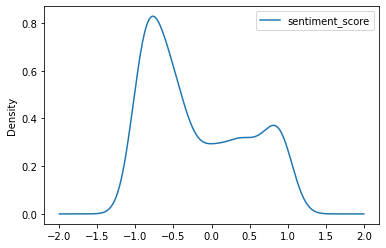

In [59]:
bad_words_rows.plot.kde(y='sentiment_score')

<AxesSubplot:ylabel='Density'>

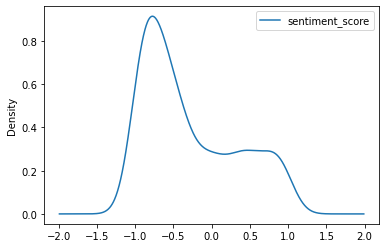

In [60]:
bad_words_rows[bad_words_rows["star_rating"] == 1].plot.kde(y='sentiment_score')

<AxesSubplot:ylabel='Density'>

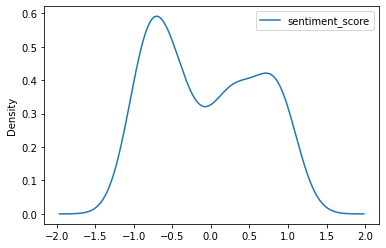

In [61]:
bad_words_rows[bad_words_rows["star_rating"] == 2].plot.kde(y='sentiment_score')

<AxesSubplot:ylabel='Density'>

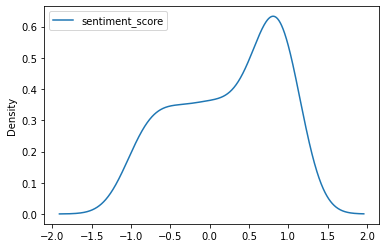

In [62]:
bad_words_rows[bad_words_rows["star_rating"] == 3].plot.kde(y='sentiment_score')

In [63]:
bad_words_rows["star_rating"].astype(int).corr(bad_words_rows["sentiment_score"].astype(float))

0.25632889626837696

In [68]:
bad_words_rows.to_csv('bad-reviews.csv', index = False, header=True)

FileNotFoundError: [Errno 2] No such file or directory: ''